## Evolutionary Algorithm Examples
### Ref : https://towardsdatascience.com/an-extensible-evolutionary-algorithm-example-in-python-7372c56a557b

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

## Main Evolutionary Algorithm Classes
## (Individual / Population / Evolution)

In [3]:
# Abstract Base Classes
class Individual(ABC):
    def __init__(self, value=None, init_params=None):
        if value is not None:
            self.value = value
        else:
            self.value = self._random_init(init_params)

    @abstractmethod
    def pair(self, other, pair_params):
        pass

    @abstractmethod
    def mutate(self, mutate_params):
        pass

    @abstractmethod
    def _random_init(self, init_params):
        pass

In [4]:
class Population:
    def __init__(self, size, fitness, individual_class, init_params):
        self.fitness = fitness
        self.individuals = [individual_class(init_params=init_params) for _ in range(size)]
        self.individuals.sort(key=lambda x: self.fitness(x))

    def replace(self, new_individuals):
        # replace low fitness individual with high fitness
        size = len(self.individuals)
        self.individuals.extend(new_individuals)
        self.individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = self.individuals[-size:]

    def get_parents(self, n_offsprings):
        mothers = self.individuals[-2 * n_offsprings::2]     # Even index
        fathers = self.individuals[-2 * n_offsprings + 1::2] # Odd index

        return mothers, fathers

In [5]:
class Evolution:
    def __init__(self, pool_size, fitness, individual_class, n_offsprings, pair_params, mutate_params, init_params):
        self.pair_params = pair_params
        self.mutate_params = mutate_params
        self.pool = Population(pool_size, fitness, individual_class, init_params)
        self.n_offsprings = n_offsprings

    def step(self):
        mothers, fathers = self.pool.get_parents(self.n_offsprings)
        offsprings = []

        for mother, father in zip(mothers, fathers):
            offspring = mother.pair(father, self.pair_params)
            offspring.mutate(self.mutate_params)
            offsprings.append(offspring)

        self.pool.replace(offsprings)

## Example -- 1D Function optimization

In [6]:
class Optimization(Individual):
    def pair(self, other, pair_params):
        new_value = pair_params['alpha'] * self.value + (1 - pair_params['alpha']) * other.value
        return Optimization(new_value)

    def mutate(self, mutate_params):
        # Random Offset
        self.value += np.random.normal(0, mutate_params['rate'], mutate_params['dim'])

        # Min / Max limitation
        for i in range(len(self.value)):
            if self.value[i] < mutate_params['lower_bound']:
                self.value[i] = mutate_params['lower_bound']
            elif self.value[i] > mutate_params['upper_bound']:
                self.value[i] = mutate_params['upper_bound']

    def _random_init(self, init_params):
        return np.random.uniform(init_params['lower_bound'], init_params['upper_bound'], init_params['dim'])

In [29]:
# Function to optimize (f(x)=-x(x-1)(x-2)(x-3)(x-4))
def fitness(opt):
    x = opt.value[0]
    return -x * (x - 1) * (x - 2) * (x - 3) * (x - 4)

# Initialize
evo = Evolution(pool_size=10, fitness=fitness, individual_class=Optimization, n_offsprings=3,
                pair_params={'alpha': 0.5},
                mutate_params={'lower_bound': 0, 'upper_bound': 4, 'rate': 0.5, 'dim': 1},
                init_params={'lower_bound': 0, 'upper_bound': 4, 'dim': 1})

<IPython.core.display.Javascript object>


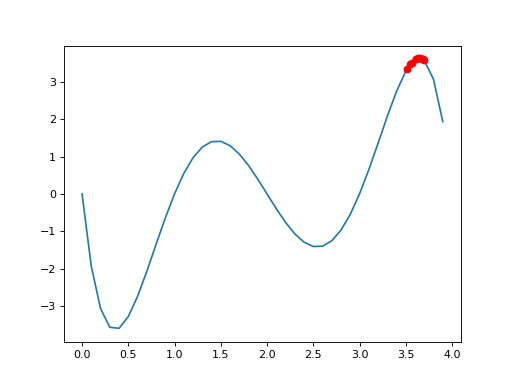

In [30]:
# Initialize Plot
fig = plt.figure()
x = np.arange(0, 4, 0.1)
plt.plot(x, -x * (x - 1) * (x - 2) * (x - 3) * (x - 4))
line, = plt.plot([], [], 'ro')

def init():
    line.set_data([], [])
    return line,

# Evolution
def evolution(i):
    evo.step()
    line.set_data([i.value[0] for i in evo.pool.individuals], 
                  [fitness(i) for i in evo.pool.individuals])
    return line,

FuncAnimation(fig, evolution, init_func=init,
              frames=50, interval=500, blit=True)